#Import Statements

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



## 🗂️ Step 2: Loading Datasets

### 📌 Sentiment Analysis Datasets
1️⃣ **Sentiment Dataset** → *Twitter Sentiment Dataset.csv*  
2️⃣ **Hate Speech Dataset** → *Twitter Sentiment Analysis (Hatred Speech) Training Dataset.csv*  
3️⃣ **Emotion Classification Dataset** → *Twitter Emotion Classification Training Dataset.csv*  
4️⃣ **Customer Support Dataset** → *Customer Support on Twitter Dataset.csv*  


In [ ]:
# Define the common directory path
base_dir = "/content/drive/MyDrive/MTech/Sem 2/Mini Project/Mini Project All/Datasets/Selected /Training datasets/"

# Define dataset file names
dataset_files = {
    "Sentiment Dataset": "Twitter Sentiment Dataset.csv",
    "Hate Speech Dataset": "Twitter Sentiment Analysis (Hatred Speech) Training Dataset.csv",
    "Emotion Classification Dataset": "Twitter Emotion Classification Training Dataset.csv",
    # "Customer Support Dataset": "Customer_Support_Updated.csv"
}


In [ ]:
# Load datasets into a dictionary
datasets = {}
for name, file in dataset_files.items():
    file_path = base_dir + file  # Construct full path
    try:
        datasets[name] = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
        print(f"✅ Loaded: {name}")
    except Exception as e:
        print(f"❌ Error loading {name}: {e}")

✅ Loaded: Sentiment Dataset
✅ Loaded: Hate Speech Dataset
✅ Loaded: Emotion Classification Dataset


Display the Datasets

In [ ]:
for name, df in datasets.items():
    print(f"\n🔹 Dataset: {name}")
    print(df.head())
    print("=" * 80)


🔹 Dataset: Sentiment Dataset
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

🔹 Dataset: Hate Speech Dataset
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

🔹 Dataset: Emotion Classification Dataset
                                                text  label
0                            i didnt feel humiliated      0
1  i can go f

#Renaming for uniformity

In [ ]:
# Rename label/category column
datasets["Sentiment Dataset"].rename(columns={"clean_text": "text", "category": "sentiment_label"}, inplace=True)
datasets["Hate Speech Dataset"].rename(columns={"tweet": "text", "label": "hate_speech_label"}, inplace=True)
datasets["Emotion Classification Dataset"].rename(columns={"label": "emotion_label"}, inplace=True)


In [ ]:
for name, df in datasets.items():
    print(f"\n🔹 Dataset: {name}")
    print(df.shape)
    print("=" * 80)


🔹 Dataset: Sentiment Dataset
(162980, 2)

🔹 Dataset: Hate Speech Dataset
(31962, 3)

🔹 Dataset: Emotion Classification Dataset
(16000, 2)


In [ ]:
for name, df in datasets.items():
    print(f"\n🔹 Dataset: {name}")
    print(df.head())
    print("=" * 80)


🔹 Dataset: Sentiment Dataset
                                                text  sentiment_label
0  when modi promised “minimum government maximum...             -1.0
1  talk all the nonsense and continue all the dra...              0.0
2  what did just say vote for modi  welcome bjp t...              1.0
3  asking his supporters prefix chowkidar their n...              1.0
4  answer who among these the most powerful world...              1.0

🔹 Dataset: Hate Speech Dataset
   id  hate_speech_label                                               text
0   1                  0   @user when a father is dysfunctional and is s...
1   2                  0  @user @user thanks for #lyft credit i can't us...
2   3                  0                                bihday your majesty
3   4                  0  #model   i love u take with u all the time in ...
4   5                  0             factsguide: society now    #motivation

🔹 Dataset: Emotion Classification Dataset
                   

In [ ]:
for name, df in datasets.items():
    print(f"\n🔹 Dataset: {name}")
    print(df.columns)
    print("=" * 80)


🔹 Dataset: Sentiment Dataset
Index(['text', 'sentiment_label'], dtype='object')

🔹 Dataset: Hate Speech Dataset
Index(['id', 'hate_speech_label', 'text'], dtype='object')

🔹 Dataset: Emotion Classification Dataset
Index(['text', 'emotion_label'], dtype='object')


#Step 3: Label transfer using training and prediction

In [ ]:
def train_and_predict_on_others_save(source_df, source_label_col,
                                     target_datasets_info, source_dataset_name,
                                     model_name='LogisticRegression', max_features=5000):

    save_dir = "/content/drive/MyDrive/MTech/Sem 2/Mini Project/Generated"
    os.makedirs(save_dir, exist_ok=True)

    source_df = source_df.dropna(subset=["text", source_label_col])

    # Train model
    X_train, X_test, y_train, y_test = train_test_split(
        source_df["text"], source_df[source_label_col], test_size=0.2, random_state=42)

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=max_features)),
        ('clf', LogisticRegression(max_iter=200))
    ])

    print(f"\n📚 Training on: {source_dataset_name}")
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    print("\n🧪 Evaluation:")
    print(classification_report(y_test, y_pred))

    # ✅ Use source dataset name for label column
    label_col_name = source_label_col

    for target_info in target_datasets_info:
        df = target_info['df']
        if "text" not in df.columns:
            print(f"⚠️ 'text' column  not found in {target_info['name']}")
            continue

        # Drop NaNs before prediction
        df_nonan = df.dropna(subset=["text"])
        predicted_labels = pipeline.predict(df_nonan["text"])

        # Add label column in-place using source dataset's name
        df.loc[df_nonan.index, label_col_name] = predicted_labels

        # Save file named after the target dataset
        filename = f"{target_info['name'].replace(' ', '_').lower()}_generated.csv"
        file_path = os.path.join(save_dir, filename)
        df.to_csv(file_path, index=False)

        print(f"\n✅ Saved: {filename}")
        print(df[["text", label_col_name]].head())


In [ ]:
train_and_predict_on_others_save(
    source_df=datasets["Emotion Classification Dataset"],
    source_label_col="emotion_label",
    target_datasets_info=[
        {"name": "Sentiment Dataset", "df": datasets["Sentiment Dataset"]},
        {"name": "Hate Speech Dataset", "df": datasets["Hate Speech Dataset"]},
        # {"name": "Customer Support Dataset", "df": datasets["Customer Support Dataset"]}
    ],
    source_dataset_name="Emotion Classification Dataset"
)



📚 Training on: Emotion Classification Dataset

🧪 Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       946
           1       0.80      0.96      0.88      1021
           2       0.89      0.60      0.72       296
           3       0.89      0.79      0.84       427
           4       0.85      0.72      0.78       397
           5       0.88      0.44      0.59       113

    accuracy                           0.85      3200
   macro avg       0.87      0.74      0.78      3200
weighted avg       0.85      0.85      0.84      3200


✅ Saved: sentiment_dataset_generated.csv
                                                text  emotion_label
0  when modi promised “minimum government maximum...            1.0
1  talk all the nonsense and continue all the dra...            0.0
2  what did just say vote for modi  welcome bjp t...            1.0
3  asking his supporters prefix chowkidar their n...            1.0
4  answer who

In [ ]:
datasets['Hate Speech Dataset'].head()

,id,hate_speech_label,text,emotion_label
0,1,0,@user when a father is dysfunctional and is s...,3.0
1,2,0,@user @user thanks for #lyft credit i can't us...,1.0
2,3,0,bihday your majesty,1.0
3,4,0,#model i love u take with u all the time in ...,1.0
4,5,0,factsguide: society now #motivation,1.0


In [ ]:
datasets['Sentiment Dataset'].head()

,text,sentiment_label,emotion_label
0,when modi promised “minimum government maximum...,-1.0,1.0
1,talk all the nonsense and continue all the dra...,0.0,0.0
2,what did just say vote for modi welcome bjp t...,1.0,1.0
3,asking his supporters prefix chowkidar their n...,1.0,1.0
4,answer who among these the most powerful world...,1.0,1.0


In [ ]:
# Use emotion classification dataset as source
train_and_predict_on_others_save(
    source_df = datasets["Sentiment Dataset"],
    source_label_col = 'sentiment_label',
    target_datasets_info=[
         {'name': 'Emotion Classification Dataset', 'df': datasets['Emotion Classification Dataset']},
         {'name': 'Hate Speech Dataset', 'df': datasets['Hate Speech Dataset']},
        # {"name": "Customer Support Dataset", "df": datasets["Customer Support Dataset"], "text_col": "text"}
    ],
    source_dataset_name="Sentiment Dataset"
)



📚 Training on: Sentiment Dataset

🧪 Evaluation:
              precision    recall  f1-score   support

        -1.0       0.91      0.83      0.87      7152
         0.0       0.92      0.98      0.95     11067
         1.0       0.94      0.94      0.94     14375

    accuracy                           0.93     32594
   macro avg       0.92      0.91      0.92     32594
weighted avg       0.93      0.93      0.93     32594


✅ Saved: emotion_classification_dataset_generated.csv
                                                text  sentiment_label
0                            i didnt feel humiliated              0.0
1  i can go from feeling so hopeless to so damned...              0.0
2   im grabbing a minute to post i feel greedy wrong             -1.0
3  i am ever feeling nostalgic about the fireplac...              0.0
4                               i am feeling grouchy              0.0

✅ Saved: hate_speech_dataset_generated.csv
                                                tex

In [ ]:
datasets['Hate Speech Dataset'].head()

,id,hate_speech_label,text,emotion_label,sentiment_label
0,1,0,@user when a father is dysfunctional and is s...,3.0,-1.0
1,2,0,@user @user thanks for #lyft credit i can't us...,1.0,1.0
2,3,0,bihday your majesty,1.0,0.0
3,4,0,#model i love u take with u all the time in ...,1.0,1.0
4,5,0,factsguide: society now #motivation,1.0,0.0


In [ ]:
datasets['Emotion Classification Dataset'].head()

,text,emotion_label,sentiment_label
0,i didnt feel humiliated,0,0.0
1,i can go from feeling so hopeless to so damned...,0,0.0
2,im grabbing a minute to post i feel greedy wrong,3,-1.0
3,i am ever feeling nostalgic about the fireplac...,2,0.0
4,i am feeling grouchy,3,0.0


In [ ]:
# Use emotion classification dataset as source
train_and_predict_on_others_save(
    source_df = datasets["Hate Speech Dataset"],
    source_label_col = 'hate_speech_label',
    target_datasets_info=[
         {'name': 'Emotion Classification Dataset', 'df': datasets['Emotion Classification Dataset']},
         {'name': 'Sentiment Dataset', 'df': datasets['Sentiment Dataset']},
        # {"name": "Customer Support Dataset", "df": datasets["Customer Support Dataset"]}
    ],
    source_dataset_name="Hate Speech Dataset"
)



📚 Training on: Hate Speech Dataset

🧪 Evaluation:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5937
           1       0.93      0.33      0.49       456

    accuracy                           0.95      6393
   macro avg       0.94      0.67      0.73      6393
weighted avg       0.95      0.95      0.94      6393


✅ Saved: emotion_classification_dataset_generated.csv
                                                text  hate_speech_label
0                            i didnt feel humiliated                0.0
1  i can go from feeling so hopeless to so damned...                0.0
2   im grabbing a minute to post i feel greedy wrong                0.0
3  i am ever feeling nostalgic about the fireplac...                0.0
4                               i am feeling grouchy                0.0

✅ Saved: sentiment_dataset_generated.csv
                                                text  hate_speech_label
0  when modi promised

In [ ]:
datasets['Emotion Classification Dataset'].head()

,text,emotion_label,sentiment_label,hate_speech_label
0,i didnt feel humiliated,0,0.0,0.0
1,i can go from feeling so hopeless to so damned...,0,0.0,0.0
2,im grabbing a minute to post i feel greedy wrong,3,-1.0,0.0
3,i am ever feeling nostalgic about the fireplac...,2,0.0,0.0
4,i am feeling grouchy,3,0.0,0.0


In [ ]:
datasets['Sentiment Dataset'].head()

,text,sentiment_label,emotion_label,hate_speech_label
0,when modi promised “minimum government maximum...,-1.0,1.0,0.0
1,talk all the nonsense and continue all the dra...,0.0,0.0,0.0
2,what did just say vote for modi welcome bjp t...,1.0,1.0,0.0
3,asking his supporters prefix chowkidar their n...,1.0,1.0,0.0
4,answer who among these the most powerful world...,1.0,1.0,0.0


#Combining the datasets

In [ ]:
import os
import pandas as pd

# Directory where generated datasets are saved
generated_dir = "/content/drive/MyDrive/MTech/Sem 2/Mini Project/Generated"

# Generated CSV files
generated_files = [
    "sentiment_dataset_generated.csv",
    "hate_speech_dataset_generated.csv",
    "emotion_classification_dataset_generated.csv",
    # "customer_support_dataset_generated.csv"
]


In [ ]:
for name, df in datasets.items():
    print(f"\n🔹 Dataset: {name}")
    print(df.head())
    print("=" * 80)


🔹 Dataset: Sentiment Dataset
                                                text  sentiment_label  \
0  when modi promised “minimum government maximum...             -1.0   
1  talk all the nonsense and continue all the dra...              0.0   
2  what did just say vote for modi  welcome bjp t...              1.0   
3  asking his supporters prefix chowkidar their n...              1.0   
4  answer who among these the most powerful world...              1.0   

   emotion_label  hate_speech_label  
0            1.0                0.0  
1            0.0                0.0  
2            1.0                0.0  
3            1.0                0.0  
4            1.0                0.0  

🔹 Dataset: Hate Speech Dataset
   id  hate_speech_label                                               text  \
0   1                  0   @user when a father is dysfunctional and is s...   
1   2                  0  @user @user thanks for #lyft credit i can't us...   
2   3                  0          

In [ ]:
# Columns you want to DROP from all datasets
drop_columns = ['id', 'ID', 'tweet_id', 'username', 'user', 'date', 'time', 'Unnamed: 0']

combined_dfs = []

for file in generated_files:
    file_path = os.path.join(generated_dir, file)
    try:
        df = pd.read_csv(file_path)
        original_cols = df.columns.tolist()

        # Detect dataset name
        dataset_name = file.replace("_generated.csv", "").lower()

        # Drop irrelevant columns if they exist
        df.drop(columns=[col for col in drop_columns if col in df.columns], inplace=True)

        # Add source_dataset tag
        df["source_dataset"] = dataset_name

        combined_dfs.append(df)
        print(f"✅ Processed: {file} → {df.shape}")

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")


✅ Processed: sentiment_dataset_generated.csv → (162980, 5)
✅ Processed: hate_speech_dataset_generated.csv → (31962, 5)
✅ Processed: emotion_classification_dataset_generated.csv → (16000, 5)


In [ ]:
# Combine all cleaned datasets
final_combined_df = pd.concat(combined_dfs, ignore_index=True)

# Save final dataset
final_path = os.path.join(generated_dir, "final_combined_dataset_cleaned.csv")
final_combined_df.to_csv(final_path, index=False)

print(f"\n🎉 Final combined dataset saved at: {final_path}")
print("🧾 Preview:")
print(final_combined_df.head())



🎉 Final combined dataset saved at: /content/drive/MyDrive/MTech/Sem 2/Mini Project/Generated/final_combined_dataset_cleaned.csv
🧾 Preview:
                                                text  sentiment_label  \
0  when modi promised “minimum government maximum...             -1.0   
1  talk all the nonsense and continue all the dra...              0.0   
2  what did just say vote for modi  welcome bjp t...              1.0   
3  asking his supporters prefix chowkidar their n...              1.0   
4  answer who among these the most powerful world...              1.0   

   emotion_label  hate_speech_label     source_dataset  
0            1.0                0.0  sentiment_dataset  
1            0.0                0.0  sentiment_dataset  
2            1.0                0.0  sentiment_dataset  
3            1.0                0.0  sentiment_dataset  
4            1.0                0.0  sentiment_dataset  


In [ ]:
final_combined_df.head(10)

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset
0,when modi promised “minimum government maximum...,-1.0,1.0,0.0,sentiment_dataset
1,talk all the nonsense and continue all the dra...,0.0,0.0,0.0,sentiment_dataset
2,what did just say vote for modi welcome bjp t...,1.0,1.0,0.0,sentiment_dataset
3,asking his supporters prefix chowkidar their n...,1.0,1.0,0.0,sentiment_dataset
4,answer who among these the most powerful world...,1.0,1.0,0.0,sentiment_dataset
5,kiya tho refresh maarkefir comment karo,0.0,1.0,0.0,sentiment_dataset
6,surat women perform yagna seeks divine grace f...,0.0,1.0,0.0,sentiment_dataset
7,this comes from cabinet which has scholars lik...,0.0,1.0,0.0,sentiment_dataset
8,with upcoming election india saga going import...,1.0,1.0,0.0,sentiment_dataset
9,gandhi was gay does modi,1.0,0.0,0.0,sentiment_dataset


#Assigning the Fine Grained and Overall Sentiment Labels

In [ ]:
# Drop rows with missing values in either label (optional)
df_filtered = final_combined_df.dropna(subset=["emotion_label", "hate_speech_label"])

# Get unique combinations
unique_combinations = df_filtered[["emotion_label", "hate_speech_label"]].drop_duplicates()

# Print each combination
print("🎯 Unique (emotion_label, hate_speech_label) combinations:\n")
for idx, row in unique_combinations.iterrows():
    print(f"🧩 Emotion: {row['emotion_label']} | Hate Speech: {row['hate_speech_label']}")


🎯 Unique (emotion_label, hate_speech_label) combinations:

🧩 Emotion: 1.0 | Hate Speech: 0.0
🧩 Emotion: 0.0 | Hate Speech: 0.0
🧩 Emotion: 3.0 | Hate Speech: 0.0
🧩 Emotion: 4.0 | Hate Speech: 0.0
🧩 Emotion: 2.0 | Hate Speech: 0.0
🧩 Emotion: 5.0 | Hate Speech: 0.0
🧩 Emotion: 0.0 | Hate Speech: 1.0
🧩 Emotion: 1.0 | Hate Speech: 1.0
🧩 Emotion: 3.0 | Hate Speech: 1.0
🧩 Emotion: 2.0 | Hate Speech: 1.0
🧩 Emotion: 4.0 | Hate Speech: 1.0
🧩 Emotion: 5.0 | Hate Speech: 1.0


#🧠 Mappings for Fine-Grained Sentiment Labels:
Emotion	Hate Speech	Meaning	Fine-Grained Sentiment Label
1.0	0.0	Joy without hate	joyful
0.0	0.0	Sadness without hate	melancholy
3.0	0.0	Anger without hate	frustrated
4.0	0.0	Fear without hate	anxious
2.0	0.0	Love without hate	affectionate
5.0	0.0	Surprise without hate	curious or shocked (contextual)
0.0	1.0	Sadness with hate speech	despairing hate
1.0	1.0	Joy with hate speech	sarcastic mockery
3.0	1.0	Anger with hate speech	aggressive hate
2.0	1.0	Love with hate speech	manipulative affection or toxic love
4.0	1.0	Fear with hate speech	fear-driven hate
5.0	1.0	Surprise with hate speech	mocking disbelief

In [ ]:
# Fine-grained emotion + hate speech label mapping
fine_grained_mapping = {
    (1.0, 0.0): "joyful",   # joy no hate
    (0.0, 0.0): "melancholy",# sad no hate
    (3.0, 0.0): "frustrated",# angry no hate
    (4.0, 0.0): "anxious",# afraid no hate
    (2.0, 0.0): "affectionate",# love no hate
    (5.0, 0.0): "curious",# surprise no hate
    (0.0, 1.0): "despairing hate", # sad hate
    (1.0, 1.0): "sarcastic mockery",# joyful hate
    (3.0, 1.0): "aggressive hate",# anger hate
    (2.0, 1.0): "toxic love",# love hate
    (4.0, 1.0): "fear-driven hate",# fear hate
    (5.0, 1.0): "mocking disbelief"# Surprise hate
}

# Sentiment label mapping
sentiment_label_mapping = {
    0: "Neutral",
    1: "Positive",
    -1: "Negative"
}

# Apply both mappings
df_filtered["fine_grained_label"] = df_filtered.apply(
    lambda row: fine_grained_mapping.get((row["emotion_label"], row["hate_speech_label"]), "unknown"),
    axis=1
)

df_filtered["sentiment_label_text"] = df_filtered["sentiment_label"].map(sentiment_label_mapping)

# ✅ Preview
print(df_filtered[["text", "sentiment_label", "sentiment_label_text", "emotion_label", "hate_speech_label", "fine_grained_label"]].head())


                                                text  sentiment_label  \
0  when modi promised “minimum government maximum...             -1.0   
1  talk all the nonsense and continue all the dra...              0.0   
2  what did just say vote for modi  welcome bjp t...              1.0   
3  asking his supporters prefix chowkidar their n...              1.0   
4  answer who among these the most powerful world...              1.0   

  sentiment_label_text  emotion_label  hate_speech_label fine_grained_label  
0             Negative            1.0                0.0             joyful  
1              Neutral            0.0                0.0         melancholy  
2             Positive            1.0                0.0             joyful  
3             Positive            1.0                0.0             joyful  
4             Positive            1.0                0.0             joyful  


<ipython-input-36-606b4d9375d4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["fine_grained_label"] = df_filtered.apply(
<ipython-input-36-606b4d9375d4>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["sentiment_label_text"] = df_filtered["sentiment_label"].map(sentiment_label_mapping)


In [ ]:
df_filtered.head(15)

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text
0,when modi promised “minimum government maximum...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative
1,talk all the nonsense and continue all the dra...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral
2,what did just say vote for modi welcome bjp t...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive
3,asking his supporters prefix chowkidar their n...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive
4,answer who among these the most powerful world...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive
5,kiya tho refresh maarkefir comment karo,0.0,1.0,0.0,sentiment_dataset,joyful,Neutral
6,surat women perform yagna seeks divine grace f...,0.0,1.0,0.0,sentiment_dataset,joyful,Neutral
7,this comes from cabinet which has scholars lik...,0.0,1.0,0.0,sentiment_dataset,joyful,Neutral
8,with upcoming election india saga going import...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive
9,gandhi was gay does modi,1.0,0.0,0.0,sentiment_dataset,melancholy,Positive


# General Sentiment Prediction again using VADER

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER Lexicon (needed only once)
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Function to get sentiment scores
def get_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return "Positive"
    elif scores['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"


In [ ]:
# Apply sentiment analysis
df_filtered['predicted_sentiment_label'] = df_filtered['text'].apply(get_sentiment)

# Display sentiment counts
df_filtered['predicted_sentiment_label'].value_counts()

<ipython-input-40-698221cfb9a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['predicted_sentiment_label'] = df_filtered['text'].apply(get_sentiment)


,count
predicted_sentiment_label,
Positive,97849
Negative,63902
Neutral,49187


In [ ]:
df_filtered.head()

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label
0,when modi promised “minimum government maximum...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative,Positive
1,talk all the nonsense and continue all the dra...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral,Negative
2,what did just say vote for modi welcome bjp t...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive
3,asking his supporters prefix chowkidar their n...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Negative
4,answer who among these the most powerful world...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive


In [ ]:
# Ensure both columns are in string form for direct comparison
match_df = df_filtered[
    df_filtered["sentiment_label_text"].notna() & df_filtered["predicted_sentiment_label"].notna()
]

# Compare the two
match_df["match"] = match_df["sentiment_label_text"] == match_df["predicted_sentiment_label"]

# Count matches and mismatches
total = len(match_df)
matches = match_df["match"].sum()
mismatches = total - matches
accuracy = matches / total * 100

print(f"✅ Total Samples Compared: {total}")
print(f"🎯 Matches: {matches}")
print(f"❌ Mismatches: {mismatches}")
print(f"📊 Match Accuracy: {accuracy:.2f}%")


✅ Total Samples Compared: 210931
🎯 Matches: 120107
❌ Mismatches: 90824
📊 Match Accuracy: 56.94%


<ipython-input-42-2c0da4dd2357>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_df["match"] = match_df["sentiment_label_text"] == match_df["predicted_sentiment_label"]


#Overall Sentiment Prediction using BERT

In [ ]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Predict sentiment for each row with neutral logic
preds = []
for text in tqdm(df_filtered["text"].dropna(), desc="Predicting Sentiment"):
    try:
        result = sentiment_pipeline(text[:512])[0]  # trim long text for BERT
        score = result["score"]
        label = result["label"]

        if 0.45 <= score <= 0.55:
            preds.append(0)  # Neutral
        elif label == "POSITIVE":
            preds.append(1)
        else:
            preds.append(-1)
    except:
        preds.append(None)

# Add predictions to DataFrame
df_filtered["bert_predicted_sentiment_label"] = preds


# Save to CSV
# df_filtered.to_csv("sentiment_check_with_transformers.csv", index=False)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
Predicting Sentiment: 100%|██████████| 210938/210938 [16:34<00:00, 212.03it/s]
<ipython-input-43-78221706482d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["bert_predicted_sentiment_label"] = preds


In [ ]:
# Map predicted_sentiment_label to numeric
predicted_sentiment_mapping = {
    "Positive": 1,
    "Neutral": 0,
    "Negative": -1
}

# Apply mapping
df_filtered["predicted_sentiment_label_numeric"] = df_filtered["predicted_sentiment_label"].map(predicted_sentiment_mapping)

# Drop old 'predicted_sentiment_label' if needed
# df_filtered = df_filtered.drop(columns=["predicted_sentiment_label"])

# Rename new column to replace old if you want
# df_filtered.rename(columns={"predicted_sentiment_label_numeric": "predicted_sentiment_label"}, inplace=True)

print(df_filtered[["text", "predicted_sentiment_label", "predicted_sentiment_label_numeric"]].head())


                                                text  \
0  when modi promised “minimum government maximum...   
1  talk all the nonsense and continue all the dra...   
2  what did just say vote for modi  welcome bjp t...   
3  asking his supporters prefix chowkidar their n...   
4  answer who among these the most powerful world...   

  predicted_sentiment_label  predicted_sentiment_label_numeric  
0                  Positive                                  1  
1                  Negative                                 -1  
2                  Positive                                  1  
3                  Negative                                 -1  
4                  Positive                                  1  


<ipython-input-44-281e81c81846>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["predicted_sentiment_label_numeric"] = df_filtered["predicted_sentiment_label"].map(predicted_sentiment_mapping)


In [ ]:
# Save final dataset
final_path = os.path.join(generated_dir, "Final.csv")
df_filtered.to_csv(final_path, index=False)

In [ ]:
# Compare with original sentiment_label
df_filtered["real_and_bert_label_mismatch"] = df_filtered["sentiment_label"] != df_filtered["bert_predicted_sentiment_label"]
df_filtered["pred_and_bert_label_mismatch"] = df_filtered["predicted_sentiment_label_numeric"] != df_filtered["bert_predicted_sentiment_label"]
df_filtered["real_and_pred_label_mismatch"] = df_filtered["predicted_sentiment_label_numeric"] != df_filtered["sentiment_label"]

df_filtered.head(15)

<ipython-input-46-19978f6c4cda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["real_and_bert_label_mismatch"] = df_filtered["sentiment_label"] != df_filtered["bert_predicted_sentiment_label"]
<ipython-input-46-19978f6c4cda>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["pred_and_bert_label_mismatch"] = df_filtered["predicted_sentiment_label_numeric"] != df_filtered["bert_predicted_sentiment_label"]
<ipython-input-46-19978f6c4cda>:4: SettingWithCopyWarning: 
A value is trying to

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,real_and_bert_label_mismatch,pred_and_bert_label_mismatch,real_and_pred_label_mismatch
0,when modi promised “minimum government maximum...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative,Positive,-1,1,False,True,True
1,talk all the nonsense and continue all the dra...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral,Negative,-1,-1,True,False,True
2,what did just say vote for modi welcome bjp t...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,-1,1,True,True,False
3,asking his supporters prefix chowkidar their n...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Negative,-1,-1,True,False,True
4,answer who among these the most powerful world...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,False,False,False
5,kiya tho refresh maarkefir comment karo,0.0,1.0,0.0,sentiment_dataset,joyful,Neutral,Neutral,1,0,True,True,False
6,surat women perform yagna seeks divine grace f...,0.0,1.0,0.0,sentiment_dataset,joyful,Neutral,Positive,1,1,True,False,True
7,this comes from cabinet which has scholars lik...,0.0,1.0,0.0,sentiment_dataset,joyful,Neutral,Positive,-1,1,True,True,True
8,with upcoming election india saga going import...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,False,False,False
9,gandhi was gay does modi,1.0,0.0,0.0,sentiment_dataset,melancholy,Positive,Neutral,-1,0,True,True,True


In [ ]:
print("Total Samples:", len(df_filtered))
print("Real vs BERT mismatches:", df_filtered["real_and_bert_label_mismatch"].sum())
print("Pred vs BERT mismatches:", df_filtered["pred_and_bert_label_mismatch"].sum())
print("Real vs Pred mismatches:", df_filtered["real_and_pred_label_mismatch"].sum())


Total Samples: 210938
Real vs BERT mismatches: 127431
Pred vs BERT mismatches: 102710
Real vs Pred mismatches: 90831


In [ ]:
total = len(df_filtered)
print("Real vs BERT mismatch %:", (df_filtered["real_and_bert_label_mismatch"].sum() / total) * 100)
print("Pred vs BERT mismatch %:", (df_filtered["pred_and_bert_label_mismatch"].sum() / total) * 100)
print("Real vs Pred mismatch %:", (df_filtered["real_and_pred_label_mismatch"].sum() / total) * 100)


Real vs BERT mismatch %: 60.411590135490044
Pred vs BERT mismatch %: 48.69203272999649
Real vs Pred mismatch %: 43.06052015284112


In [ ]:
disagreement_samples = df_filtered[df_filtered["real_and_bert_label_mismatch"] == True]
disagreement_samples[["text", "sentiment_label", "bert_predicted_sentiment_label"]].head(200)


,text,sentiment_label,bert_predicted_sentiment_label
1,talk all the nonsense and continue all the dra...,0.0,-1
2,what did just say vote for modi welcome bjp t...,1.0,-1
3,asking his supporters prefix chowkidar their n...,1.0,-1
5,kiya tho refresh maarkefir comment karo,0.0,1
6,surat women perform yagna seeks divine grace f...,0.0,1
...,...,...,...
306,thatvis during upa ruling these modishah duo a...,0.0,-1
309,congress party and its desire make powerful on...,1.0,-1
311,inc doing better with modishah the helm bjp no...,1.0,-1
312,still hybernatingur frnd nirav modi got arrest...,1.0,-1


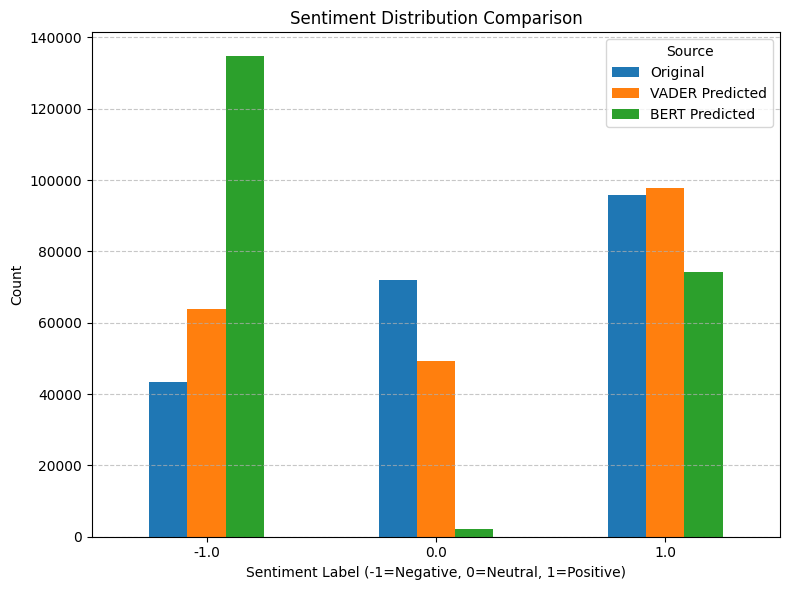

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with all sentiment distributions
sentiment_counts = pd.DataFrame({
    "Original": df_filtered["sentiment_label"].value_counts().sort_index(),
    "VADER Predicted": df_filtered["predicted_sentiment_label_numeric"].value_counts().sort_index(),
    "BERT Predicted": df_filtered["bert_predicted_sentiment_label"].value_counts().sort_index()
}).sort_index()

# Plot them side-by-side
sentiment_counts.plot(kind="bar", figsize=(8, 6), rot=0)
plt.title("Sentiment Distribution Comparison")
plt.xlabel("Sentiment Label (-1=Negative, 0=Neutral, 1=Positive)")
plt.ylabel("Count")
plt.legend(title="Source")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Calculate mismatch percentages
total = len(df_filtered)
mismatch_vader = np.mean(df_filtered["sentiment_label"] != df_filtered["predicted_sentiment_label_numeric"]) * 100
mismatch_bert = np.mean(df_filtered["sentiment_label"] != df_filtered["bert_predicted_sentiment_label"]) * 100

print(f"Mismatch with VADER predictions: {mismatch_vader:.2f}%")
print(f"Mismatch with BERT predictions: {mismatch_bert:.2f}%")


Mismatch with VADER predictions: 43.06%
Mismatch with BERT predictions: 60.41%


In [ ]:
df_filtered.to_csv("Combined.csv", index=False)


#EDA on the Combined Dataset

In [ ]:
combined= pd.read_csv("/content/drive/MyDrive/MTech/Sem 2/Mini Project/Generated/Final.csv")

In [ ]:
combined.head()

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric
0,when modi promised “minimum government maximum...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative,Positive,-1,1
1,talk all the nonsense and continue all the dra...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral,Negative,-1,-1
2,what did just say vote for modi welcome bjp t...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,-1,1
3,asking his supporters prefix chowkidar their n...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Negative,-1,-1
4,answer who among these the most powerful world...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210938 entries, 0 to 210937
Data columns (total 10 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   text                               210938 non-null  object 
 1   sentiment_label                    210931 non-null  float64
 2   emotion_label                      210938 non-null  float64
 3   hate_speech_label                  210938 non-null  float64
 4   source_dataset                     210938 non-null  object 
 5   fine_grained_label                 210938 non-null  object 
 6   sentiment_label_text               210931 non-null  object 
 7   predicted_sentiment_label          210938 non-null  object 
 8   bert_predicted_sentiment_label     210938 non-null  int64  
 9   predicted_sentiment_label_numeric  210938 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 16.1+ MB


In [ ]:
combined.describe()

,sentiment_label,emotion_label,hate_speech_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric
count,210931.000000,210938.000000,210938.000000,210938.000000,210938.000000
mean,0.248712,0.907916,0.011638,-0.287118,0.160934
std,0.772597,0.743210,0.107252,0.952672,0.860768
min,-1.000000,0.000000,0.000000,-1.000000,-1.000000
25%,0.000000,1.000000,0.000000,-1.000000,-1.000000
50%,0.000000,1.000000,0.000000,-1.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,5.000000,1.000000,1.000000,1.000000


In [ ]:
combined.columns

Index(['text', 'sentiment_label', 'emotion_label', 'hate_speech_label',
       'source_dataset', 'fine_grained_label', 'sentiment_label_text',
       'predicted_sentiment_label', 'bert_predicted_sentiment_label',
       'predicted_sentiment_label_numeric'],
      dtype='object')

In [ ]:
combined.shape

(210938, 10)

In [ ]:
combined.dropna(inplace=True)

In [ ]:
combined.shape

(210931, 10)

In [ ]:
# Assuming df is your combined dataset
print(combined['fine_grained_label'].value_counts())
print(combined['sentiment_label_text'].value_counts())


fine_grained_label
joyful               150445
melancholy            46237
frustrated             4952
anxious                3719
affectionate           2154
sarcastic mockery      1807
curious                 969
despairing hate         529
aggressive hate          90
toxic love               11
fear-driven hate          9
mocking disbelief         9
Name: count, dtype: int64
sentiment_label_text
Positive    95707
Neutral     71978
Negative    43246
Name: count, dtype: int64


### weighted ensemble voting across BERT, VADER, and Rule-based sentiment predictions to determine a final overall sentiment label

In [ ]:
import pandas as pd
from collections import Counter

# Define your weights (tweak based on your confidence in each model)
weights = {
    "bert": 0.4,
    "vader": 0.3,
    "rule": 0.3
}

def weighted_vote(row):
    sentiments = {
        row["bert_predicted_sentiment_label"]: weights["bert"],
        row["predicted_sentiment_label_numeric"]: weights["vader"],
        row["sentiment_label"]: weights["rule"]
    }

    # Aggregate weights for each label
    total_weights = {}
    for label, weight in sentiments.items():
        total_weights[label] = total_weights.get(label, 0) + weight

    # Choose the label with highest aggregated weight
    final_sentiment = max(total_weights.items(), key=lambda x: x[1])[0]
    return final_sentiment

# Apply to your DataFrame
combined["final_sentiment"] = combined.apply(weighted_vote, axis=1)


In [ ]:
def weighted_vote_with_tie_breaker(row):
    sentiments = {
        row["bert_predicted_sentiment_label"]: weights["bert"],
        row["predicted_sentiment_label_numeric"]: weights["vader"],
        row["sentiment_label"]: weights["rule"]
    }

    total_weights = {}
    for label, weight in sentiments.items():
        total_weights[label] = total_weights.get(label, 0) + weight

    # Get top 2 sentiments
    sorted_items = sorted(total_weights.items(), key=lambda x: x[1], reverse=True)

    if len(sorted_items) > 1 and sorted_items[0][1] == sorted_items[1][1]:
        # Tie-break: prefer neutral if it exists among top
        top_labels = [sorted_items[0][0], sorted_items[1][0]]
        if "neutral" in top_labels:
            return "neutral"
        else:
            return sorted_items[0][0]
    return sorted_items[0][0]

combined["final_sentiment"] = combined.apply(weighted_vote_with_tie_breaker, axis=1)


In [ ]:
combined

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,final_sentiment
0,when modi promised “minimum government maximum...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative,Positive,-1,1,-1
1,talk all the nonsense and continue all the dra...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral,Negative,-1,-1,-1
2,what did just say vote for modi welcome bjp t...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,-1,1,-1
3,asking his supporters prefix chowkidar their n...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Negative,-1,-1,-1
4,answer who among these the most powerful world...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
210933,i just had a very brief time in the beanbag an...,1.0,0.0,0.0,emotion_classification_dataset,melancholy,Positive,Negative,-1,-1,-1
210934,i am now turning and i feel pathetic that i am...,-1.0,0.0,0.0,emotion_classification_dataset,melancholy,Negative,Negative,-1,-1,-1
210935,i feel strong and good overall,1.0,1.0,0.0,emotion_classification_dataset,joyful,Positive,Positive,1,1,1
210936,i feel like this was such a rude comment and i...,1.0,3.0,0.0,emotion_classification_dataset,frustrated,Positive,Positive,-1,1,-1


In [ ]:
combined[[
    "text", "final_sentiment", "bert_predicted_sentiment_label", "predicted_sentiment_label_numeric","sentiment_label_text"
]]

,text,final_sentiment,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,sentiment_label_text
0,when modi promised “minimum government maximum...,-1,-1,1,Negative
1,talk all the nonsense and continue all the dra...,-1,-1,-1,Neutral
2,what did just say vote for modi welcome bjp t...,-1,-1,1,Positive
3,asking his supporters prefix chowkidar their n...,-1,-1,-1,Positive
4,answer who among these the most powerful world...,1,1,1,Positive
...,...,...,...,...,...
210933,i just had a very brief time in the beanbag an...,-1,-1,-1,Positive
210934,i am now turning and i feel pathetic that i am...,-1,-1,-1,Negative
210935,i feel strong and good overall,1,1,1,Positive
210936,i feel like this was such a rude comment and i...,-1,-1,1,Positive


In [ ]:
# Define the mapping for integer labels to text labels
sentiment_mapping = {
    -1: "Negative",   # Negative sentiment
    0: "Neutral",     # Neutral sentiment
    1: "Positive"     # Positive sentiment
}

# Example function to map integer sentiment labels to text labels
def map_sentiment_to_text(sentiment_int):
    return sentiment_mapping.get(sentiment_int, "Unknown")  # Default to "Unknown" if not in the mapping

# Example usage
combined['final_sentiment_label'] = combined['final_sentiment'].apply(map_sentiment_to_text)

# Show the dataframe with the final text labels
combined[["text", "final_sentiment", "final_sentiment_label"]]


,text,final_sentiment,final_sentiment_label
0,when modi promised “minimum government maximum...,-1,Negative
1,talk all the nonsense and continue all the dra...,-1,Negative
2,what did just say vote for modi welcome bjp t...,-1,Negative
3,asking his supporters prefix chowkidar their n...,-1,Negative
4,answer who among these the most powerful world...,1,Positive
...,...,...,...
210933,i just had a very brief time in the beanbag an...,-1,Negative
210934,i am now turning and i feel pathetic that i am...,-1,Negative
210935,i feel strong and good overall,1,Positive
210936,i feel like this was such a rude comment and i...,-1,Negative


#Valiadtion of the combined dataset labels

In [ ]:
import pandas as pd

# Updated rule logic for your emotion and hate label combinations
def validate_labels(row):
    flags = []

    # Lowercase and strip for consistent comparison
    fg_label = row['fine_grained_label'].strip().lower()
    sentiment = row['sentiment_label_text'].strip().lower()

    # Rule 1: Emotion + Hate Speech should match expected fine-grained label
    expected_fine = {
        (1.0, 0.0): "joyful",
        (0.0, 0.0): "melancholy",
        (3.0, 0.0): "frustrated",
        (4.0, 0.0): "anxious",
        (2.0, 0.0): "affectionate",
        (5.0, 0.0): "curious or shocked (contextual)",

        (0.0, 1.0): "despairing hate",
        (1.0, 1.0): "sarcastic mockery",
        (3.0, 1.0): "aggressive hate",
        (2.0, 1.0): "manipulative affection or toxic love",
        (4.0, 1.0): "fear-driven hate",
        (5.0, 1.0): "mocking disbelief"
    }

    key = (row['emotion_label'], row['hate_speech_label'])
    expected_fg = expected_fine.get(key)

    if expected_fg and fg_label != expected_fg.strip().lower():
        flags.append(f"Mismatch: Expected '{expected_fg}' for (emotion={key[0]}, hate={key[1]})")

    # Rule 2: Simplified sentiment check for broad mapping
    expected_sentiment = {
        "joyful": "positive",
        "affectionate": "positive",
        "curious or shocked (contextual)": "neutral",
        "melancholy": "negative",
        "frustrated": "negative",
        "anxious": "negative",

        "despairing hate": "negative",
        "sarcastic mockery": "negative",
        "aggressive hate": "negative",
        "manipulative affection or toxic love": "negative",
        "fear-driven hate": "negative",
        "mocking disbelief": "negative"
    }

    expected_sent = expected_sentiment.get(fg_label)
    if expected_sent and sentiment != expected_sent:
        flags.append(f"Mismatch: Sentiment should be '{expected_sent}' for fine-grained label '{fg_label}'")

    # Optional Rule 3: Flag happy/neutral emotions marked as hate speech
    if row['hate_speech_label'] == 1 and row['emotion_label'] in [0.0, 1.0]:
        flags.append("Suspicious: Hate speech marked with sad/joyful emotion")

    return "; ".join(flags) if flags else None

# Apply validation
combined["validation_flags"] = combined.apply(validate_labels, axis=1)

# View problematic rows
combined[combined["validation_flags"].notnull()][[
    "text", "emotion_label", "hate_speech_label",
    "fine_grained_label", "final_sentiment_label", "bert_predicted_sentiment_label", "predicted_sentiment_label_numeric","sentiment_label_text" ,"validation_flags"
]]


,text,emotion_label,hate_speech_label,fine_grained_label,final_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,sentiment_label_text,validation_flags
0,when modi promised “minimum government maximum...,1.0,0.0,joyful,Negative,-1,1,Negative,Mismatch: Sentiment should be 'positive' for f...
1,talk all the nonsense and continue all the dra...,0.0,0.0,melancholy,Negative,-1,-1,Neutral,Mismatch: Sentiment should be 'negative' for f...
5,kiya tho refresh maarkefir comment karo,1.0,0.0,joyful,Positive,1,0,Neutral,Mismatch: Sentiment should be 'positive' for f...
6,surat women perform yagna seeks divine grace f...,1.0,0.0,joyful,Positive,1,1,Neutral,Mismatch: Sentiment should be 'positive' for f...
7,this comes from cabinet which has scholars lik...,1.0,0.0,joyful,Negative,-1,1,Neutral,Mismatch: Sentiment should be 'positive' for f...
...,...,...,...,...,...,...,...,...,...
210927,i need to do this that and the other for colle...,5.0,0.0,curious,Negative,-1,-1,Negative,Mismatch: Expected 'curious or shocked (contex...
210930,i moved away he said something that made me fe...,3.0,0.0,frustrated,Negative,-1,-1,Neutral,Mismatch: Sentiment should be 'negative' for f...
210932,i feel so sympathetic empathetic towards them,2.0,0.0,affectionate,Positive,1,1,Neutral,Mismatch: Sentiment should be 'positive' for f...
210933,i just had a very brief time in the beanbag an...,0.0,0.0,melancholy,Negative,-1,-1,Positive,Mismatch: Sentiment should be 'negative' for f...


In [ ]:
import pandas as pd

# Updated rule logic for your emotion and hate label combinations
def validate_labels(row):
    flags = []

    # Lowercase and strip for consistent comparison
    fg_label = row['fine_grained_label'].strip().lower()
    sentiment = row['final_sentiment_label'].strip().lower()

    # Rule 1: Emotion + Hate Speech should match expected fine-grained label
    expected_fine = {
        (1.0, 0.0): "joyful",
        (0.0, 0.0): "melancholy",
        (3.0, 0.0): "frustrated",
        (4.0, 0.0): "anxious",
        (2.0, 0.0): "affectionate",
        (5.0, 0.0): "curious or shocked (contextual)",

        (0.0, 1.0): "despairing hate",
        (1.0, 1.0): "sarcastic mockery",
        (3.0, 1.0): "aggressive hate",
        (2.0, 1.0): "manipulative affection or toxic love",
        (4.0, 1.0): "fear-driven hate",
        (5.0, 1.0): "mocking disbelief"
    }

    key = (row['emotion_label'], row['hate_speech_label'])
    expected_fg = expected_fine.get(key)

    if expected_fg and fg_label != expected_fg.strip().lower():
        flags.append(f"Mismatch: Expected '{expected_fg}' for (emotion={key[0]}, hate={key[1]})")

    # Rule 2: Simplified sentiment check for broad mapping
    expected_sentiment = {
        "joyful": "positive",
        "affectionate": "positive",
        "curious or shocked (contextual)": "neutral",
        "melancholy": "negative",
        "frustrated": "negative",
        "anxious": "negative",

        "despairing hate": "negative",
        "sarcastic mockery": "negative",
        "aggressive hate": "negative",
        "manipulative affection or toxic love": "negative",
        "fear-driven hate": "negative",
        "mocking disbelief": "negative"
    }

    expected_sent = expected_sentiment.get(fg_label)
    if expected_sent and sentiment != expected_sent:
        flags.append(f"Mismatch: Sentiment should be '{expected_sent}' for fine-grained label '{fg_label}'")

    # Optional Rule 3: Flag happy/neutral emotions marked as hate speech
    if row['hate_speech_label'] == 1 and row['emotion_label'] in [0.0, 1.0]:
        flags.append("Suspicious: Hate speech marked with sad/joyful emotion")

    return "; ".join(flags) if flags else None

# Apply validation
combined["final_validation_flags"] = combined.apply(validate_labels, axis=1)

# View problematic rows
combined[combined["validation_flags"].notnull()][[
    "text", "emotion_label", "hate_speech_label",
    "fine_grained_label", "final_sentiment_label", "bert_predicted_sentiment_label", "predicted_sentiment_label_numeric","sentiment_label_text" ,"validation_flags","final_validation_flags"
]]


,text,emotion_label,hate_speech_label,fine_grained_label,final_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,sentiment_label_text,validation_flags,final_validation_flags
0,when modi promised “minimum government maximum...,1.0,0.0,joyful,Negative,-1,1,Negative,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Sentiment should be 'positive' for f...
1,talk all the nonsense and continue all the dra...,0.0,0.0,melancholy,Negative,-1,-1,Neutral,Mismatch: Sentiment should be 'negative' for f...,None
5,kiya tho refresh maarkefir comment karo,1.0,0.0,joyful,Positive,1,0,Neutral,Mismatch: Sentiment should be 'positive' for f...,None
6,surat women perform yagna seeks divine grace f...,1.0,0.0,joyful,Positive,1,1,Neutral,Mismatch: Sentiment should be 'positive' for f...,None
7,this comes from cabinet which has scholars lik...,1.0,0.0,joyful,Negative,-1,1,Neutral,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Sentiment should be 'positive' for f...
...,...,...,...,...,...,...,...,...,...,...
210927,i need to do this that and the other for colle...,5.0,0.0,curious,Negative,-1,-1,Negative,Mismatch: Expected 'curious or shocked (contex...,Mismatch: Expected 'curious or shocked (contex...
210930,i moved away he said something that made me fe...,3.0,0.0,frustrated,Negative,-1,-1,Neutral,Mismatch: Sentiment should be 'negative' for f...,None
210932,i feel so sympathetic empathetic towards them,2.0,0.0,affectionate,Positive,1,1,Neutral,Mismatch: Sentiment should be 'positive' for f...,None
210933,i just had a very brief time in the beanbag an...,0.0,0.0,melancholy,Negative,-1,-1,Positive,Mismatch: Sentiment should be 'negative' for f...,None


In [ ]:
# Count records where there is no mismatch (validation_flags is None or empty)
no_mismatch_count = combined[combined['validation_flags'].isna() | (combined['validation_flags'] == '')].shape[0]

# Display the count
print(f"Number of records with no mismatch without ensemble( using original labels): {no_mismatch_count}")


Number of records with no mismatch without ensemble( using original labels): 97762


In [ ]:
# Count records where there is no mismatch (validation_flags is None or empty)
no_mismatch_count = combined[combined['final_validation_flags'].isna() | (combined['final_validation_flags'] == '')].shape[0]

# Display the count
print(f"Number of records with no mismatch with ensemble: {no_mismatch_count}")


Number of records with no mismatch with ensemble: 106211


###Investigating the Mismatch Records

In [ ]:
import pandas as pd

# Filter out rows where there is no mismatch in the validation_flags column
mismatch_records = combined[combined['validation_flags'].notnull()]

mismatch_analysis = mismatch_records[['text', 'sentiment_label_text', 'fine_grained_label', 'validation_flags']]

mismatch_analysis.head(10)

mismatch_count = mismatch_records['validation_flags'].value_counts()

print(f"Mismatches breakdown:\n{mismatch_count}")

mismatch_by_sentiment = mismatch_records[['sentiment_label_text', 'fine_grained_label', 'validation_flags']].groupby('sentiment_label_text').size()

print(f"Mismatched records by sentiment label:\n{mismatch_by_sentiment}")


Mismatches breakdown:
validation_flags
Mismatch: Sentiment should be 'positive' for fine-grained label 'joyful'                                                                       73923
Mismatch: Sentiment should be 'negative' for fine-grained label 'melancholy'                                                                   30045
Mismatch: Sentiment should be 'negative' for fine-grained label 'frustrated'                                                                    2803
Mismatch: Sentiment should be 'negative' for fine-grained label 'anxious'                                                                       2418
Mismatch: Sentiment should be 'negative' for fine-grained label 'sarcastic mockery'; Suspicious: Hate speech marked with sad/joyful emotion     1466
Mismatch: Expected 'curious or shocked (contextual)' for (emotion=5.0, hate=0.0)                                                                 969
Mismatch: Sentiment should be 'positive' for fine-grained label 'af

In [ ]:
import pandas as pd

# Filter out rows where there is no mismatch in the validation_flags column
mismatch_records = combined[combined['final_validation_flags'].notnull()]

mismatch_analysis = mismatch_records[['text', 'sentiment_label_text', 'fine_grained_label', 'final_validation_flags']]

mismatch_analysis.head(10)

mismatch_count = mismatch_records['final_validation_flags'].value_counts()

print(f"Mismatches breakdown:\n{mismatch_count}")

mismatch_by_sentiment = mismatch_records[['sentiment_label_text', 'fine_grained_label', 'final_validation_flags']].groupby('sentiment_label_text').size()

print(f"Mismatched records by sentiment label:\n{mismatch_by_sentiment}")


Mismatches breakdown:
final_validation_flags
Mismatch: Sentiment should be 'positive' for fine-grained label 'joyful'                                                                       89366
Mismatch: Sentiment should be 'negative' for fine-grained label 'melancholy'                                                                    9775
Suspicious: Hate speech marked with sad/joyful emotion                                                                                          1984
Mismatch: Expected 'curious or shocked (contextual)' for (emotion=5.0, hate=0.0)                                                                 969
Mismatch: Sentiment should be 'positive' for fine-grained label 'affectionate'                                                                   788
Mismatch: Sentiment should be 'negative' for fine-grained label 'frustrated'                                                                     758
Mismatch: Sentiment should be 'negative' for fine-grained lab

###Validation of fineGrained labels using text

In [ ]:
import pandas as pd

# Sample validation function for fine-grained sentiment labels based on text
def validate_fine_grained_label_with_text(row):
    flags = []

    fine_grained = row['fine_grained_label'].lower()
    text = row['text'].lower()

    # Rule 1: Positive fine-grained labels (e.g., 'joyful', 'affectionate')
    positive_words = ['love', 'great', 'wonderful', 'amazing', 'delightful', 'happy', 'joyful', 'excited', 'optimistic']
    if fine_grained in ['joyful', 'happy', 'affectionate', 'optimistic']:
        if not any(word in text for word in positive_words):
            flags.append(f"Mismatch: Fine-grained label '{fine_grained}' should have positive expressions but found no positive words in text.")

    # Rule 2: Negative fine-grained labels (e.g., 'angry', 'frustrated', 'melancholy')
    angry_words = ['hate', 'angry', 'furious', 'enraged', 'frustrated', 'annoyed']
    if fine_grained == 'angry':
        if not any(word in text for word in angry_words):
            flags.append(f"Mismatch: Fine-grained label '{fine_grained}' should have angry expressions but found none in text.")

    frustrated_words = ['stuck', 'annoyed', 'fed up', 'helpless']
    if fine_grained == 'frustrated':
        if not any(word in text for word in frustrated_words):
            flags.append(f"Mismatch: Fine-grained label '{fine_grained}' should have frustration-related words but found none in text.")

    sad_words = ['lost', 'alone', 'disappointed', 'heartbroken', 'depressed']
    if fine_grained == 'melancholy':
        if not any(word in text for word in sad_words):
            flags.append(f"Mismatch: Fine-grained label '{fine_grained}' should have sad-related words but found none in text.")

    # Rule 3: Neutral fine-grained labels (e.g., 'neutral', 'apathetic')
    neutral_words = ['meh', 'whatever', 'couldn\'t care less']
    if fine_grained == 'neutral':
        if not any(word in text for word in neutral_words):
            flags.append(f"Mismatch: Fine-grained label '{fine_grained}' should have neutral expressions but found no neutral words in text.")

    # Rule 4: Sarcastic fine-grained labels
    sarcastic_words = ['oh great', 'sure, that\'s wonderful', 'fantastic', 'yeah right']
    if fine_grained == 'sarcastic':
        if not any(word in text for word in sarcastic_words):
            flags.append(f"Mismatch: Fine-grained label '{fine_grained}' should have sarcastic expressions but found none in text.")

    # Rule 5: Hate-related fine-grained labels (e.g., 'despairing hate', 'aggressive hate')
    despairing_words = ['destroy', 'ruin', 'no hope', 'nothing good', 'end', 'worthless']
    if fine_grained == 'despairing hate':
        if not any(word in text for word in despairing_words):
            flags.append(f"Mismatch: Fine-grained label '{fine_grained}' should have despairing hate words but found none in text.")

    aggressive_words = ['kill', 'destroy', 'rage', 'hurt', 'blood', 'violence']
    if fine_grained == 'aggressive hate':
        if not any(word in text for word in aggressive_words):
            flags.append(f"Mismatch: Fine-grained label '{fine_grained}' should have aggressive hate words but found none in text.")

    # Return flags if any mismatches
    return "; ".join(flags) if flags else None


# Apply validation to the dataframe
combined['fine_grained_validation_flags'] = combined.apply(validate_fine_grained_label_with_text, axis=1)

combined[['text', 'fine_grained_label', 'fine_grained_validation_flags']]


,text,fine_grained_label,fine_grained_validation_flags
0,when modi promised “minimum government maximum...,joyful,Mismatch: Fine-grained label 'joyful' should h...
1,talk all the nonsense and continue all the dra...,melancholy,Mismatch: Fine-grained label 'melancholy' shou...
2,what did just say vote for modi welcome bjp t...,joyful,Mismatch: Fine-grained label 'joyful' should h...
3,asking his supporters prefix chowkidar their n...,joyful,None
4,answer who among these the most powerful world...,joyful,Mismatch: Fine-grained label 'joyful' should h...
...,...,...,...
210933,i just had a very brief time in the beanbag an...,melancholy,Mismatch: Fine-grained label 'melancholy' shou...
210934,i am now turning and i feel pathetic that i am...,melancholy,Mismatch: Fine-grained label 'melancholy' shou...
210935,i feel strong and good overall,joyful,Mismatch: Fine-grained label 'joyful' should h...
210936,i feel like this was such a rude comment and i...,frustrated,Mismatch: Fine-grained label 'frustrated' shou...


In [ ]:
import pandas as pd

# Filter out rows where there is no mismatch in the validation_flags column
mismatch_records = combined[combined['fine_grained_validation_flags'].notnull()]

mismatch_analysis = mismatch_records[['text', 'fine_grained_label', 'fine_grained_validation_flags']]

mismatch_analysis.head(10)

mismatch_count = mismatch_records['fine_grained_validation_flags'].value_counts()

print(f"Mismatches breakdown:\n{mismatch_count}")

mismatch_by_sentiment = mismatch_records[['fine_grained_label', 'fine_grained_validation_flags']].groupby('fine_grained_label').size()

print(f"Mismatched records by sentiment label:\n{mismatch_by_sentiment}")


Mismatches breakdown:
fine_grained_validation_flags
Mismatch: Fine-grained label 'joyful' should have positive expressions but found no positive words in text.          137703
Mismatch: Fine-grained label 'melancholy' should have sad-related words but found none in text.                       44100
Mismatch: Fine-grained label 'frustrated' should have frustration-related words but found none in text.                4853
Mismatch: Fine-grained label 'affectionate' should have positive expressions but found no positive words in text.      1527
Mismatch: Fine-grained label 'despairing hate' should have despairing hate words but found none in text.                503
Mismatch: Fine-grained label 'aggressive hate' should have aggressive hate words but found none in text.                 87
Name: count, dtype: int64
Mismatched records by sentiment label:
fine_grained_label
affectionate         1527
aggressive hate        87
despairing hate       503
frustrated           4853
joyful          

In [ ]:
combined.columns

Index(['text', 'sentiment_label', 'emotion_label', 'hate_speech_label',
       'source_dataset', 'fine_grained_label', 'sentiment_label_text',
       'predicted_sentiment_label', 'bert_predicted_sentiment_label',
       'predicted_sentiment_label_numeric', 'final_sentiment',
       'final_sentiment_label', 'validation_flags', 'final_validation_flags',
       'fine_grained_validation_flags'],
      dtype='object')

In [ ]:
import pandas as pd

# Assuming your DataFrame is named `combined` and has the following columns:
# 'text', 'original_sentiment', 'bert_sentiment', 'vader_sentiment', 'fine_grained_label'

# Step 1: Ensemble label (only when BERT and VADER agree)
def get_ensemble_sentiment(row):
    if row['bert_predicted_sentiment_label'] == row['predicted_sentiment_label_numeric']:
        return row['bert_predicted_sentiment_label']
    else:
        return 'uncertain'

combined['ensemble_sentiment'] = combined.apply(get_ensemble_sentiment, axis=1)

# Step 2: Map fine-grained emotion labels to expected sentiments
emotion_to_sentiment = {
    'joy': 'positive', 'love': 'positive', 'affectionate': 'positive',
    'sadness': 'negative', 'melancholy': 'negative', 'frustrated': 'negative',
    'anger': 'negative', 'fear': 'negative', 'surprise': 'neutral', 'neutral': 'neutral',
    'despairing hate': 'negative', 'aggressive hate': 'negative', 'sarcastic mockery': 'negative',
    'toxic love': 'negative', 'fear-driven hate': 'negative', 'mocking disbelief': 'negative',
    'hate': 'negative'
}

# Step 3: Use fine-grained sentiment to resolve uncertain ensemble
def resolve_sentiment(row):
    if row['ensemble_sentiment'] != 'uncertain':
        return row['ensemble_sentiment']
    expected = emotion_to_sentiment.get(row['fine_grained_label'], 'neutral')
    if row['sentiment_label_text'] == expected:
        return row['sentiment_label_text']
    return 'uncertain'

combined['overall_sentiment'] = combined.apply(resolve_sentiment, axis=1)


#sample the dataset for faster computation

In [ ]:
combined

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,final_sentiment,final_sentiment_label,validation_flags,final_validation_flags,fine_grained_validation_flags,ensemble_sentiment,overall_sentiment
0,when modi promised “minimum government maximum...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative,Positive,-1,1,-1,Negative,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Fine-grained label 'joyful' should h...,uncertain,uncertain
1,talk all the nonsense and continue all the dra...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'negative' for f...,None,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1
2,what did just say vote for modi welcome bjp t...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,-1,1,-1,Negative,None,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Fine-grained label 'joyful' should h...,uncertain,uncertain
3,asking his supporters prefix chowkidar their n...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Negative,-1,-1,-1,Negative,None,Mismatch: Sentiment should be 'positive' for f...,None,-1,-1
4,answer who among these the most powerful world...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210933,i just had a very brief time in the beanbag an...,1.0,0.0,0.0,emotion_classification_dataset,melancholy,Positive,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'negative' for f...,None,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1
210934,i am now turning and i feel pathetic that i am...,-1.0,0.0,0.0,emotion_classification_dataset,melancholy,Negative,Negative,-1,-1,-1,Negative,None,None,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1
210935,i feel strong and good overall,1.0,1.0,0.0,emotion_classification_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1
210936,i feel like this was such a rude comment and i...,1.0,3.0,0.0,emotion_classification_dataset,frustrated,Positive,Positive,-1,1,-1,Negative,Mismatch: Sentiment should be 'negative' for f...,None,Mismatch: Fine-grained label 'frustrated' shou...,uncertain,uncertain


In [ ]:
clean_sentiment_df = combined[combined['overall_sentiment'] != 'uncertain']


In [ ]:
clean_sentiment_df

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,final_sentiment,final_sentiment_label,validation_flags,final_validation_flags,fine_grained_validation_flags,ensemble_sentiment,overall_sentiment
1,talk all the nonsense and continue all the dra...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'negative' for f...,None,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1
3,asking his supporters prefix chowkidar their n...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Negative,-1,-1,-1,Negative,None,Mismatch: Sentiment should be 'positive' for f...,None,-1,-1
4,answer who among these the most powerful world...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1
6,surat women perform yagna seeks divine grace f...,0.0,1.0,0.0,sentiment_dataset,joyful,Neutral,Positive,1,1,1,Positive,Mismatch: Sentiment should be 'positive' for f...,None,Mismatch: Fine-grained label 'joyful' should h...,1,1
8,with upcoming election india saga going import...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210932,i feel so sympathetic empathetic towards them,0.0,2.0,0.0,emotion_classification_dataset,affectionate,Neutral,Positive,1,1,1,Positive,Mismatch: Sentiment should be 'positive' for f...,None,Mismatch: Fine-grained label 'affectionate' sh...,1,1
210933,i just had a very brief time in the beanbag an...,1.0,0.0,0.0,emotion_classification_dataset,melancholy,Positive,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'negative' for f...,None,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1
210934,i am now turning and i feel pathetic that i am...,-1.0,0.0,0.0,emotion_classification_dataset,melancholy,Negative,Negative,-1,-1,-1,Negative,None,None,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1
210935,i feel strong and good overall,1.0,1.0,0.0,emotion_classification_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1


In [ ]:
clean_sentiment_df.shape

(108226, 17)

In [ ]:
import pandas as pd
# Make sure we're only working with valid, clean data
df = combined[(combined['overall_sentiment'] != 'uncertain') & (combined['fine_grained_label'].notna())]
# Map numeric sentiments to strings

sentiment_map = {-1: "negative", 0: "neutral", 1: "positive"}

df['sentiment_str'] = df['final_sentiment'].map(sentiment_map)

# Step 1: Create a joint column for stratification
df['stratify_col'] = df['sentiment_str'] + " | " + df['fine_grained_label']

# Drop rows with missing 'sentiment_str' or 'stratify_col' (if any)
df = df.dropna(subset=['sentiment_str', 'stratify_col'])

# Count the size of each stratification group
group_counts = df['stratify_col'].value_counts()

# Keep only those with at least 2 samples
valid_strata = group_counts[group_counts >= 2].index

df_filtered = df[df['stratify_col'].isin(valid_strata)].copy()


# Step 2: Sample N% of the data with stratification
# For example, sample 20% of the dataset
sample_frac = 0.2

df_sampled, _ = train_test_split(
    df_filtered,
    test_size=1 - sample_frac,
    stratify=df_filtered['stratify_col'],
    random_state=42
)

# Optional: Drop the helper stratification column
df_sampled = df_sampled.drop(columns=['stratify_col'])


<ipython-input-40-ec558cef49e5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_str'] = df['final_sentiment'].map(sentiment_map)
<ipython-input-40-ec558cef49e5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stratify_col'] = df['sentiment_str'] + " | " + df['fine_grained_label']


In [ ]:
df_sampled

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,final_sentiment,final_sentiment_label,validation_flags,final_validation_flags,fine_grained_validation_flags,ensemble_sentiment,overall_sentiment,sentiment_str
61774,india joins the elite club congratulations all...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive
140803,this pure bravery only firing bullets and ches...,1.0,0.0,0.0,sentiment_dataset,melancholy,Positive,Positive,1,1,1,Positive,Mismatch: Sentiment should be 'negative' for f...,Mismatch: Sentiment should be 'negative' for f...,Mismatch: Fine-grained label 'melancholy' shou...,1,1,positive
35068,you are true you have guts then the video wher...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive
22078,when modi was destroying economy with demoneti...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Fine-grained label 'joyful' should h...,-1,-1,negative
47113,excellent,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161315,aur modi the best are country quite pappu bahi,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive
151667,chumma blabber modi been screwing the patriots...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'negative' for f...,None,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1,negative
149506,not for bjp but certainly the rest the opposit...,-1.0,0.0,0.0,sentiment_dataset,melancholy,Negative,Negative,-1,-1,-1,Negative,None,None,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1,negative
40764,1145 modi addressing the nation important mess...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive


In [ ]:
df_sampled.shape

(21644, 18)

In [ ]:
df_sampled.describe()

,sentiment_label,emotion_label,hate_speech_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,final_sentiment
count,21644.000000,21644.000000,21644.000000,21644.000000,21644.000000,21644.000000
mean,0.241822,0.933192,0.010488,-0.061772,-0.061772,-0.061772
std,0.824595,0.822943,0.101874,0.994984,0.994984,0.994984
min,-1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_sampled.isnull().sum()

,0
text,0
sentiment_label,0
emotion_label,0
hate_speech_label,0
source_dataset,0
fine_grained_label,0
sentiment_label_text,0
predicted_sentiment_label,0
bert_predicted_sentiment_label,0
predicted_sentiment_label_numeric,0


#Zero shot classification for fine grained labels

In [ ]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Initialize the zero-shot pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)  # use device=0 for GPU

# Fine-grained labels
fine_grained_labels = [
    "sadness", "joy", "love", "anger", "fear", "surprise", "neutral", "hate"
]

# Parameters
batch_size = 32
texts = df_sampled["text"].tolist()
predicted_labels = []

# Batched classification
for i in tqdm(range(0, len(texts), batch_size), desc="Zero-shot classification"):
    batch = texts[i:i+batch_size]
    results = classifier(batch, candidate_labels=fine_grained_labels, multi_label=False)

    if isinstance(results, dict):  # handle single item
        predicted_labels.append(results['labels'][0])
    else:
        for r in results:
            predicted_labels.append(r['labels'][0])

# Assign to DataFrame
df_sampled["predicted_fine_grained"] = predicted_labels


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Zero-shot classification: 100%|██████████| 677/677 [1:04:07<00:00,  5.68s/it]


In [ ]:
df_sampled["predicted_fine_grained"]

,predicted_fine_grained
61774,joy
140803,surprise
35068,surprise
22078,surprise
47113,joy
...,...
161315,joy
151667,hate
149506,surprise
40764,surprise


In [ ]:
df_sampled

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,final_sentiment,final_sentiment_label,validation_flags,final_validation_flags,fine_grained_validation_flags,ensemble_sentiment,overall_sentiment,sentiment_str,predicted_fine_grained
61774,india joins the elite club congratulations all...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy
140803,this pure bravery only firing bullets and ches...,1.0,0.0,0.0,sentiment_dataset,melancholy,Positive,Positive,1,1,1,Positive,Mismatch: Sentiment should be 'negative' for f...,Mismatch: Sentiment should be 'negative' for f...,Mismatch: Fine-grained label 'melancholy' shou...,1,1,positive,surprise
35068,you are true you have guts then the video wher...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,surprise
22078,when modi was destroying economy with demoneti...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Fine-grained label 'joyful' should h...,-1,-1,negative,surprise
47113,excellent,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161315,aur modi the best are country quite pappu bahi,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy
151667,chumma blabber modi been screwing the patriots...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'negative' for f...,None,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1,negative,hate
149506,not for bjp but certainly the rest the opposit...,-1.0,0.0,0.0,sentiment_dataset,melancholy,Negative,Negative,-1,-1,-1,Negative,None,None,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1,negative,surprise
40764,1145 modi addressing the nation important mess...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,None,None,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,surprise


<ipython-input-48-6d9defe37b36>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


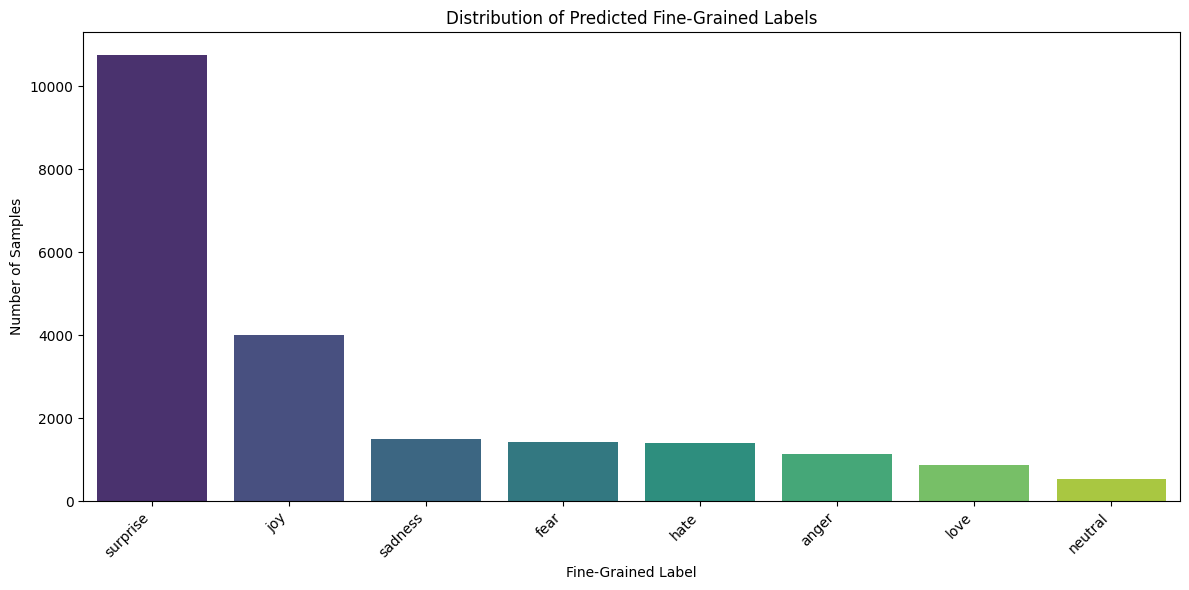

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count label occurrences
label_counts = df_sampled["predicted_fine_grained"].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Predicted Fine-Grained Labels")
plt.xlabel("Fine-Grained Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()


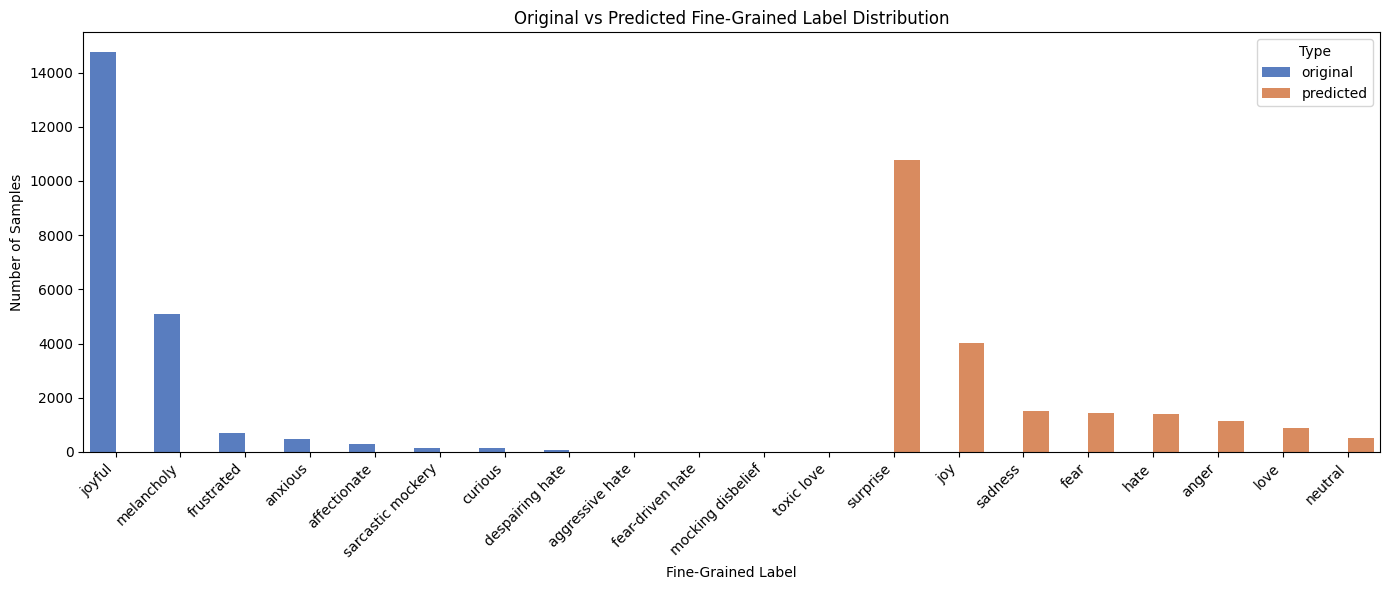

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count original and predicted labels
orig_counts = df_sampled["fine_grained_label"].value_counts().rename("original")
pred_counts = df_sampled["predicted_fine_grained"].value_counts().rename("predicted")

# Combine into one DataFrame
compare_df = pd.concat([orig_counts, pred_counts], axis=1).fillna(0).astype(int)
compare_df = compare_df.reset_index().melt(id_vars="index", var_name="Type", value_name="Count")
compare_df.rename(columns={"index": "Label"}, inplace=True)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=compare_df, x="Label", y="Count", hue="Type", palette="muted")
plt.xticks(rotation=45, ha='right')
plt.title("Original vs Predicted Fine-Grained Label Distribution")
plt.xlabel("Fine-Grained Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()


###Validation of Original Labels with Predicted Labels:


In [ ]:
import pandas as pd


# Create a DataFrame for easier visualization of mismatches
validation_df = pd.DataFrame({
    "Original Label": original_labels,
    "Predicted Label": predicted_labels
})

# Check for mismatches
validation_df['Match'] = validation_df['Original Label'] == validation_df['Predicted Label']

# Count mismatches
mismatch_count = validation_df[validation_df['Match'] == False]

print("Mismatch Breakdown:")
print(mismatch_count)

# Optionally, define validation rules for fine-grained sentiment labels
def validate_labels(text, predicted_label):
    # Define rule-based checks for the fine-grained labels
    validation_rules = {
        "joyful": ["happy", "excited", "joy", "delighted", "cheerful"],
        "melancholy": ["sad", "down", "gloomy", "depressed", "sorrow"],
        "frustrated": ["irritated", "angry", "annoyed", "upset"],
        "affectionate": ["love", "care", "dear", "sweet", "fond"],
        "despairing hate": ["hopeless", "despair", "hate", "anger"],
        "aggressive hate": ["rage", "violence", "aggressive", "intense hatred"],
        "sarcastic mockery": ["mocking", "sarcasm", "ridicule", "snide"],
        "toxic love": ["toxic", "abusive", "obsessive", "manipulative"]
    }

    # Check if the predicted label matches any of the rules
    for label, keywords in validation_rules.items():
        if predicted_label == label:
            if not any(keyword in text.lower() for keyword in keywords):
                print(f"Warning: '{predicted_label}' label does not match expected keywords in the text.")
                return False
            return True
    return False

# Validate the predicted labels
for idx, row in validation_df.iterrows():
    text = texts[idx]
    predicted_label = row["Predicted Label"]
    is_valid = validate_labels(text, predicted_label)
    print(f"Text: {text}\nPredicted Label: {predicted_label} | Validation Result: {'Valid' if is_valid else 'Invalid'}\n")


#Modeling and Evaluation using combined dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
from transformers import pipeline
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm import tqdm

# Make sure your sampled DataFrame is ready
df = pd.read_csv("/content/drive/MyDrive/Mini Project/Generated/sampled.csv") # or your actual sampled DataFrame


In [ ]:
df

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,final_sentiment,final_sentiment_label,validation_flags,final_validation_flags,fine_grained_validation_flags,ensemble_sentiment,overall_sentiment,sentiment_str,predicted_fine_grained
0,india joins the elite club congratulations all...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy
1,this pure bravery only firing bullets and ches...,1.0,0.0,0.0,sentiment_dataset,melancholy,Positive,Positive,1,1,1,Positive,Mismatch: Sentiment should be 'negative' for f...,Mismatch: Sentiment should be 'negative' for f...,Mismatch: Fine-grained label 'melancholy' shou...,1,1,positive,surprise
2,you are true you have guts then the video wher...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,surprise
3,when modi was destroying economy with demoneti...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Fine-grained label 'joyful' should h...,-1,-1,negative,surprise
4,excellent,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21639,aur modi the best are country quite pappu bahi,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy
21640,chumma blabber modi been screwing the patriots...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral,Negative,-1,-1,-1,Negative,Mismatch: Sentiment should be 'negative' for f...,NaN,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1,negative,hate
21641,not for bjp but certainly the rest the opposit...,-1.0,0.0,0.0,sentiment_dataset,melancholy,Negative,Negative,-1,-1,-1,Negative,NaN,NaN,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1,negative,surprise
21642,1145 modi addressing the nation important mess...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,1,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,surprise


In [ ]:
# Map numeric labels to string
sentiment_map = {-1: "negative", 0: "neutral", 1: "positive"}
df['true_overall'] = df['overall_sentiment'].map(sentiment_map)

# Load sentiment analysis pipeline
sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Predict
predicted_overall = []
for text in tqdm(df['text'], desc="Predicting overall sentiment"):
    result = sentiment_model(text[:512])[0]
    predicted_overall.append(result['label'].lower())

df['pred_overall'] = predicted_overall

# Accuracy
overall_accuracy = accuracy_score(df['true_overall'], df['pred_overall'])
print(f"✅ Overall Sentiment Accuracy: {overall_accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0
Predicting overall sentiment: 100%|██████████| 21644/21644 [03:18<00:00, 109.28it/s]

✅ Overall Sentiment Accuracy: 0.0000


In [ ]:
df

,text,sentiment_label,emotion_label,hate_speech_label,source_dataset,fine_grained_label,sentiment_label_text,predicted_sentiment_label,bert_predicted_sentiment_label,predicted_sentiment_label_numeric,...,final_sentiment_label,validation_flags,final_validation_flags,fine_grained_validation_flags,ensemble_sentiment,overall_sentiment,sentiment_str,predicted_fine_grained,true_overall,pred_overall
0,india joins the elite club congratulations all...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,...,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy,positive,label_2
1,this pure bravery only firing bullets and ches...,1.0,0.0,0.0,sentiment_dataset,melancholy,Positive,Positive,1,1,...,Positive,Mismatch: Sentiment should be 'negative' for f...,Mismatch: Sentiment should be 'negative' for f...,Mismatch: Fine-grained label 'melancholy' shou...,1,1,positive,surprise,positive,label_1
2,you are true you have guts then the video wher...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,...,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,surprise,positive,label_1
3,when modi was destroying economy with demoneti...,-1.0,1.0,0.0,sentiment_dataset,joyful,Negative,Negative,-1,-1,...,Negative,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Sentiment should be 'positive' for f...,Mismatch: Fine-grained label 'joyful' should h...,-1,-1,negative,surprise,negative,label_0
4,excellent,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,...,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy,positive,label_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21639,aur modi the best are country quite pappu bahi,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,...,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,joy,positive,label_2
21640,chumma blabber modi been screwing the patriots...,0.0,0.0,0.0,sentiment_dataset,melancholy,Neutral,Negative,-1,-1,...,Negative,Mismatch: Sentiment should be 'negative' for f...,NaN,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1,negative,hate,negative,label_0
21641,not for bjp but certainly the rest the opposit...,-1.0,0.0,0.0,sentiment_dataset,melancholy,Negative,Negative,-1,-1,...,Negative,NaN,NaN,Mismatch: Fine-grained label 'melancholy' shou...,-1,-1,negative,surprise,negative,label_0
21642,1145 modi addressing the nation important mess...,1.0,1.0,0.0,sentiment_dataset,joyful,Positive,Positive,1,1,...,Positive,NaN,NaN,Mismatch: Fine-grained label 'joyful' should h...,1,1,positive,surprise,positive,label_1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Sampled dataset assumed to be loaded as df_sampled with 'text', 'final_sentiment', and 'mapped_fine_grained'
# Map numerical sentiment labels to strings for classification

# Split data for overall sentiment
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(
    df["text"], df["sentiment_str"], test_size=0.2, stratify=df["sentiment_str"], random_state=42
)

# Split data for fine-grained sentiment
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    df["text"], df["predicted_fine_grained"], test_size=0.2, stratify=df["predicted_fine_grained"], random_state=42
)

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_o_vec = vectorizer.fit_transform(X_train_o)
X_test_o_vec = vectorizer.transform(X_test_o)
X_train_f_vec = vectorizer.fit_transform(X_train_f)
X_test_f_vec = vectorizer.transform(X_test_f)

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB()
}

results = {"overall": {}, "fine_grained": {}}

# Train and evaluate models
for name, model in models.items():
    # Overall Sentiment
    model.fit(X_train_o_vec, y_train_o)
    preds_o = model.predict(X_test_o_vec)
    acc_o = accuracy_score(y_test_o, preds_o)
    results["overall"][name] = {
        "accuracy": acc_o,
        "report": classification_report(y_test_o, preds_o, output_dict=True)
    }

    # Fine-Grained Sentiment
    model.fit(X_train_f_vec, y_train_f)
    preds_f = model.predict(X_test_f_vec)
    acc_f = accuracy_score(y_test_f, preds_f)
    results["fine_grained"][name] = {
        "accuracy": acc_f,
        "report": classification_report(y_test_f, preds_f, output_dict=True)
    }


results


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

{'overall': {'Logistic Regression': {'accuracy': 0.8951258951258951,
   'report': {'negative': {'precision': 0.8887952822240943,
     'recall': 0.9234135667396062,
     'f1-score': 0.9057737711955355,
     'support': 2285.0},
    'neutral': {'precision': 0.0,
     'recall': 0.0,
     'f1-score': 0.0,
     'support': 27.0},
    'positive': {'precision': 0.9028132992327366,
     'recall': 0.8750619732275657,
     'f1-score': 0.8887210473313192,
     'support': 2017.0},
    'accuracy': 0.8951258951258951,
    'macro avg': {'precision': 0.5972028604856102,
     'recall': 0.599491846655724,
     'f1-score': 0.5981649395089516,
     'support': 4329.0},
    'weighted avg': {'precision': 0.8897832396476056,
     'recall': 0.8951258951258951,
     'f1-score': 0.8921791221180572,
     'support': 4329.0}}},
  'Random Forest': {'accuracy': 0.8103488103488103,
   'report': {'negative': {'precision': 0.7949740725967291,
     'recall': 0.8722100656455142,
     'f1-score': 0.8318030050083473,
     'su

In [ ]:
import pandas as pd

# Print accuracy tables
overall_acc = {model: round(info["accuracy"], 4) for model, info in results["overall"].items()}
fine_grained_acc = {model: round(info["accuracy"], 4) for model, info in results["fine_grained"].items()}

print("\nAccuracy Table:")
accuracy_df = pd.DataFrame({
    "Overall Sentiment": overall_acc,
    "Fine-Grained Sentiment": fine_grained_acc
})
print(accuracy_df.T)

# Print classification report summaries
def extract_summary(report_dict):
    return {
        "precision": round(report_dict["weighted avg"]["precision"], 4),
        "recall": round(report_dict["weighted avg"]["recall"], 4),
        "f1-score": round(report_dict["weighted avg"]["f1-score"], 4)
    }

overall_report = {model: extract_summary(info["report"]) for model, info in results["overall"].items()}
fine_grained_report = {model: extract_summary(info["report"]) for model, info in results["fine_grained"].items()}

print("\nClassification Report Summary (Weighted Avg):")
report_df = pd.concat([
    pd.DataFrame(overall_report).T.rename(columns=lambda c: f"Overall - {c}"),
    pd.DataFrame(fine_grained_report).T.rename(columns=lambda c: f"Fine-Grained - {c}")
], axis=1)

report_df



Accuracy Table:
                        Logistic Regression  Random Forest  Naive Bayes
Overall Sentiment                    0.8951         0.8103       0.8644
Fine-Grained Sentiment               0.6523         0.6399       0.5819

Classification Report Summary (Weighted Avg):


,Overall - precision,Overall - recall,Overall - f1-score,Fine-Grained - precision,Fine-Grained - recall,Fine-Grained - f1-score
Logistic Regression,0.8898,0.8951,0.8922,0.6823,0.6523,0.6086
Random Forest,0.8132,0.8103,0.8071,0.6735,0.6399,0.5929
Naive Bayes,0.8611,0.8644,0.8611,0.6700,0.5819,0.4837


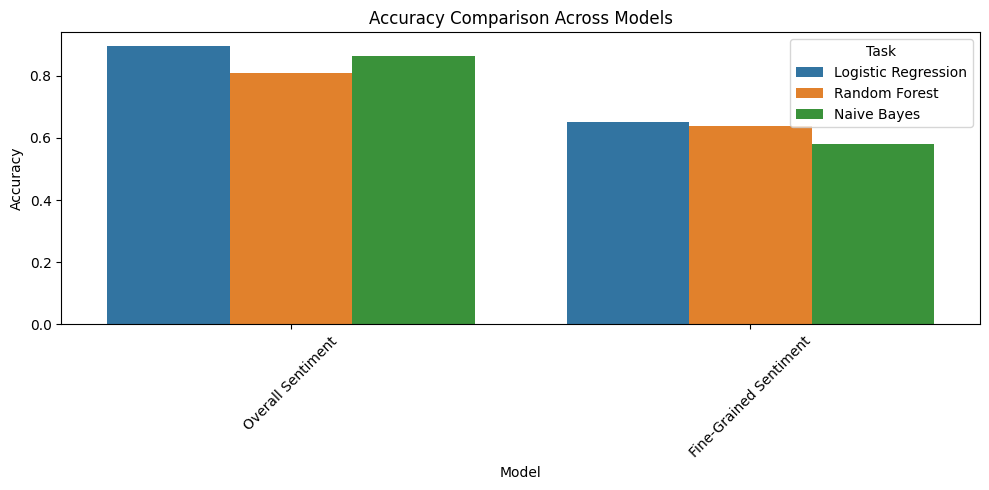

<ipython-input-12-4bd7a03d11a3>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-12-4bd7a03d11a3>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
<ipython-input-12-4bd7a03d11a3>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


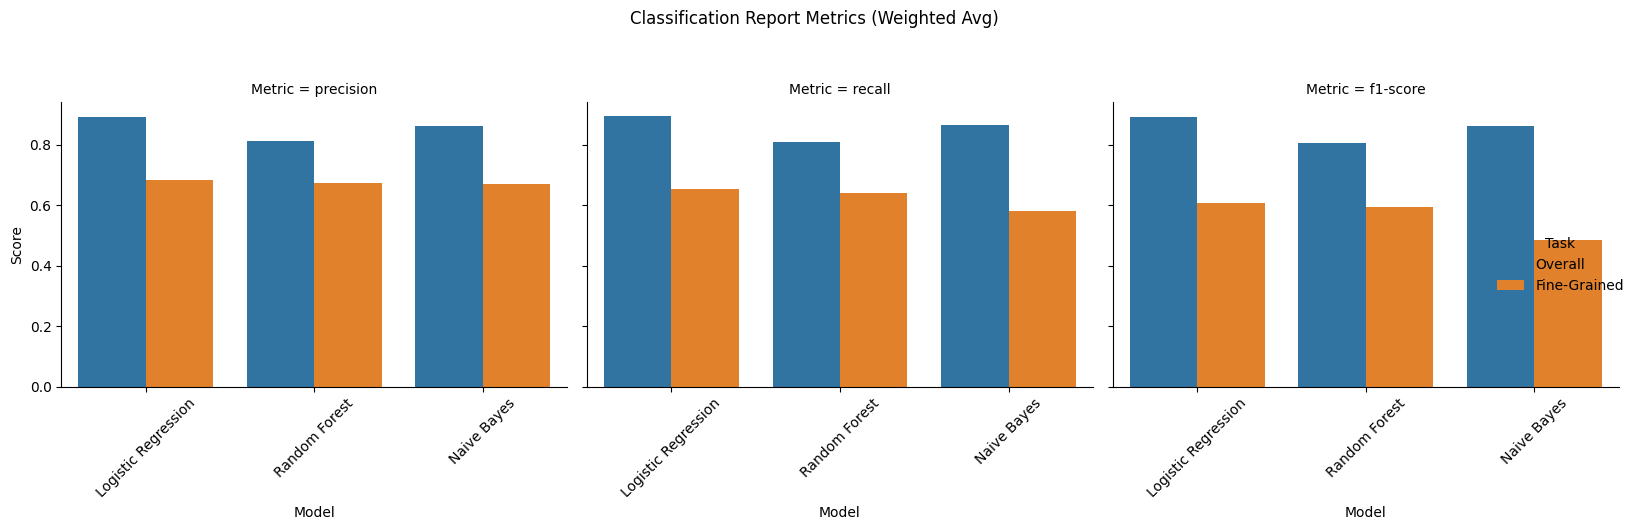

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare accuracy data for plotting
accuracy_df_reset = accuracy_df.T.reset_index().melt(id_vars='index', var_name='Task', value_name='Accuracy')
accuracy_df_reset.columns = ['Model', 'Task', 'Accuracy']

# Prepare classification report metrics
report_df_reset = report_df.reset_index().melt(id_vars='index', var_name='Metric_Combined', value_name='Score')
report_df_reset[['Task', 'Metric']] = report_df_reset['Metric_Combined'].str.split(' - ', expand=True)
report_df_reset = report_df_reset[['index', 'Task', 'Metric', 'Score']]
report_df_reset.columns = ['Model', 'Task', 'Metric', 'Score']

# Plot Accuracy
plt.figure(figsize=(10, 5))
sns.barplot(data=accuracy_df_reset, x='Model', y='Accuracy', hue='Task')
plt.title('Accuracy Comparison Across Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Classification Report Metrics
g = sns.catplot(
    data=report_df_reset, kind='bar',
    x='Model', y='Score', hue='Task', col='Metric',
    height=5, aspect=1
)
g.fig.suptitle('Classification Report Metrics (Weighted Avg)', y=1.05)
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, ClassLabel
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# Model name
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizer function
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

# Encode labels
le_overall = LabelEncoder()
le_fine = LabelEncoder()
df["sentiment_encoded"] = le_overall.fit_transform(df["sentiment_str"])
df["fine_encoded"] = le_fine.fit_transform(df["predicted_fine_grained"])

# Convert to Hugging Face Datasets
dataset_overall = Dataset.from_pandas(df[["text", "sentiment_encoded"]].rename(columns={"sentiment_encoded": "labels"}))
dataset_fine = Dataset.from_pandas(df[["text", "fine_encoded"]].rename(columns={"fine_encoded": "labels"}))

# Cast labels to ClassLabel
overall_label_cls = ClassLabel(num_classes=len(le_overall.classes_), names=[str(x) for x in range(len(le_overall.classes_))])
fine_label_cls = ClassLabel(num_classes=len(le_fine.classes_), names=[str(x) for x in range(len(le_fine.classes_))])

dataset_overall = dataset_overall.cast_column("labels", overall_label_cls)
dataset_fine = dataset_fine.cast_column("labels", fine_label_cls)

# Tokenize
dataset_overall = dataset_overall.map(tokenize, batched=True)
dataset_fine = dataset_fine.map(tokenize, batched=True)

# Stratified train/test split
dataset_overall = dataset_overall.train_test_split(test_size=0.2, stratify_by_column="labels")
dataset_fine = dataset_fine.train_test_split(test_size=0.2, stratify_by_column="labels")

# Metric function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Train and evaluate function
def train_transformer_model(dataset, num_labels, task_name):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    training_args = TrainingArguments(
        output_dir=f"./results_{task_name}",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir=f"./logs_{task_name}",
        logging_steps=500
    )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result

# Train models
bert_overall_results = train_transformer_model(dataset_overall, num_labels=len(le_overall.classes_), task_name="overall")
bert_fine_results = train_transformer_model(dataset_fine, num_labels=len(le_fine.classes_), task_name="fine_grained")

# Print results
print("\n[Transformer Model Results]")
print("Overall Sentiment:", bert_overall_results)
print("Fine-Grained Sentiment:", bert_fine_results)


Casting the dataset:   0%|          | 0/21644 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/21644 [00:00<?, ? examples/s]

Map:   0%|          | 0/21644 [00:00<?, ? examples/s]

Map:   0%|          | 0/21644 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-aca7e7618b14>:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.329300
1000,0.225100
1500,0.208600
2000,0.189300
2500,0.098800
3000,0.093200
3500,0.078100
4000,0.079400


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-aca7e7618b14>:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,1.324100
1000,0.990300
1500,0.906300
2000,0.845300
2500,0.744800
3000,0.642500
3500,0.636400
4000,0.628100



[Transformer Model Results]
Overall Sentiment: {'eval_loss': 0.1656179130077362, 'eval_accuracy': 0.9651189651189651, 'eval_precision': 0.9641480379859851, 'eval_recall': 0.9651189651189651, 'eval_f1': 0.9643599853900309, 'eval_runtime': 11.9445, 'eval_samples_per_second': 362.427, 'eval_steps_per_second': 45.377, 'epoch': 2.0}
Fine-Grained Sentiment: {'eval_loss': 0.8114356994628906, 'eval_accuracy': 0.7355047355047355, 'eval_precision': 0.7304068270063149, 'eval_recall': 0.7355047355047355, 'eval_f1': 0.7286357169832821, 'eval_runtime': 11.8076, 'eval_samples_per_second': 366.628, 'eval_steps_per_second': 45.903, 'epoch': 2.0}


In [ ]:
# Add Transformer results to your existing results dictionary
results["overall"]["DistilBERT"] = {
    "accuracy": round(bert_overall_results["eval_accuracy"], 4),
    "report": {
        "weighted avg": {
            "precision": round(bert_overall_results["eval_precision"], 4),
            "recall": round(bert_overall_results["eval_recall"], 4),
            "f1-score": round(bert_overall_results["eval_f1"], 4)
        }
    }
}

results["fine_grained"]["DistilBERT"] = {
    "accuracy": round(bert_fine_results["eval_accuracy"], 4),
    "report": {
        "weighted avg": {
            "precision": round(bert_fine_results["eval_precision"], 4),
            "recall": round(bert_fine_results["eval_recall"], 4),
            "f1-score": round(bert_fine_results["eval_f1"], 4)
        }
    }
}


In [ ]:
# Accuracy table
overall_acc = {model: round(info["accuracy"], 4) for model, info in results["overall"].items()}
fine_grained_acc = {model: round(info["accuracy"], 4) for model, info in results["fine_grained"].items()}

print("\nUpdated Accuracy Table:")
accuracy_df = pd.DataFrame({
    "Overall Sentiment": overall_acc,
    "Fine-Grained Sentiment": fine_grained_acc
})
print(accuracy_df.T)

# Classification report summaries
def extract_summary(report_dict):
    return {
        "precision": round(report_dict["weighted avg"]["precision"], 4),
        "recall": round(report_dict["weighted avg"]["recall"], 4),
        "f1-score": round(report_dict["weighted avg"]["f1-score"], 4)
    }

overall_report = {model: extract_summary(info["report"]) for model, info in results["overall"].items()}
fine_grained_report = {model: extract_summary(info["report"]) for model, info in results["fine_grained"].items()}

report_df = pd.concat([
    pd.DataFrame(overall_report).T.rename(columns=lambda c: f"Overall - {c}"),
    pd.DataFrame(fine_grained_report).T.rename(columns=lambda c: f"Fine-Grained - {c}")
], axis=1)



Updated Accuracy Table:
                        Logistic Regression  Random Forest  Naive Bayes  \
Overall Sentiment                    0.8951         0.8103       0.8644   
Fine-Grained Sentiment               0.6523         0.6399       0.5819   

                        DistilBERT  
Overall Sentiment           0.9651  
Fine-Grained Sentiment      0.7355  


<ipython-input-31-af925fd98a19>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=report_df_reset, x='Model', y='Score', hue='Metric', palette='Set2', ci=None)


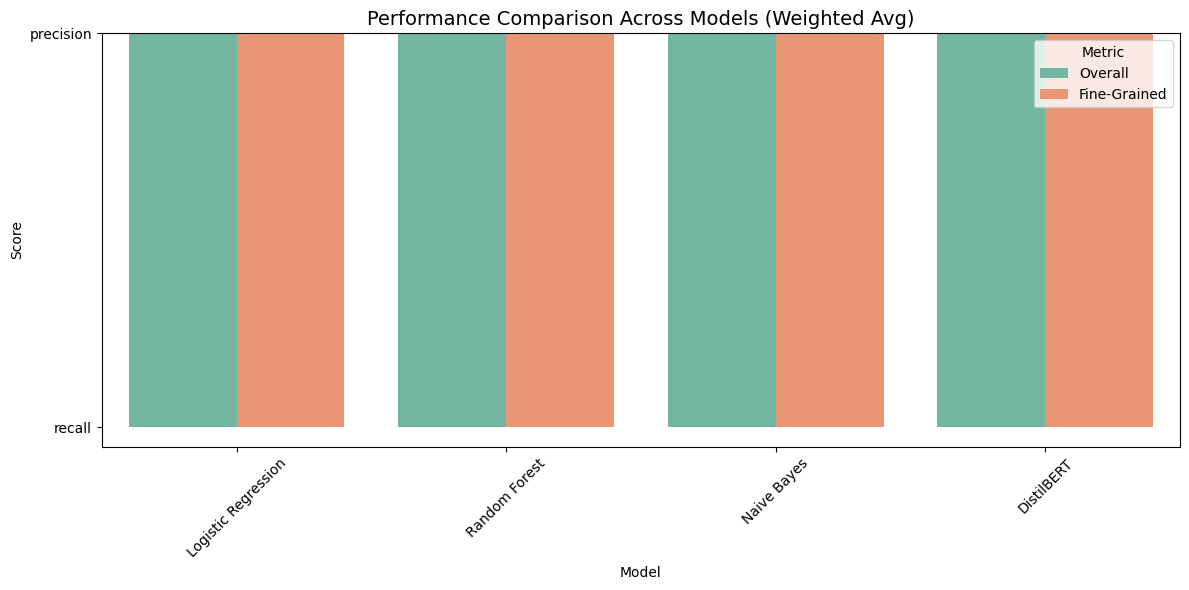

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt dataframe for seaborn
report_df_reset = report_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
report_df_reset[['Task', 'Metric']] = report_df_reset['Metric'].str.split(' - ', expand=True)
report_df_reset.columns = ['Model', 'Score', 'Task', 'Metric']
report_df_reset = report_df_reset[['Model', 'Task', 'Metric', 'Score']]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=report_df_reset, x='Model', y='Score', hue='Metric', palette='Set2', ci=None)
plt.title('Performance Comparison Across Models (Weighted Avg)', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df_sampled.to_csv("/content/drive/MyDrive/MTech/Sem 2/Mini Project/Generated/sampled.csv", index=False)